## Problem

Na raspolaganju nam je skup podataka o pacijentima koji su imali uspešnu terapiju elektrokonverzijom. Naš zadatak je da napravimo klasifikacioni model koji predviđa da li će se sinusni ritam rada srca pacijenta održati i nakon godinu dana od terapije.
Osnovni pristup podrazumeva kreiranje modela Bajesovske mreže.

## Učitavanje podataka

In [51]:
import pandas as pd
import numpy as np
data = pd.read_csv('./elektrokonverzija_obradjeno.csv', index_col=0)
print(data.columns)

Index(['Broj', 'godine starosti', 'stariji od 65', 'Pol',
       'indikacija: perzistentna',
       'ukupno trajanje AF (kada je prvi put dijagnostikovana) u mesecima',
       'trajanje ove epizode AF u mesecima',
       'frekvenca komora na prijemnom EKG-u', 'Blok grane', 'dimenzija LPK',
       'EDD LK', 'ESD LK', 'EF LK', 'MR', 'TR', 'HTA', 'DM', 'HLP', 'HOBP',
       'pušenje', 'Hereditet za KVB', 'ishemijska bolest srca', 'HF',
       'NYHA klasa (ukoliko ima HF)', 'Prethodni TIA/CVI', 'HBI', 'CHADS-Vasc',
       'poremećaj f-je štitaste žlezde', 'dosadašnje elektrokonverzije',
       'SCD (Structural heart disease)', 'Beta blokatori', 'ACE inhibitori',
       'ARB', 'Furosemid (ne - 0)', 'Drugi diuretik', 'Spironolakton',
       'Ca antagonisti', 'Amiodaron', 'Propafen', 'Flekainid', 'Sotalol',
       'Digoksin', 'ASA', 'OAKT', 'Plavix', 'Statin', 'Implantiran CIED',
       'Vreme u mesecima od ugradnje aparata do elektrokonverzije',
       'sinhroni, bifazni DC šok', 'Elektrokon

### Podela podataka na skup za trening i skup za test

Skup podataka delimo na skup za trening modela i skup za testiranje modela.
Argument random_state ima vrednost 0 da bi se svaku put dobio isto podeljen skup, kako bismo mogli da upoređujemo modele. Argument stratifz ima vrednost ciljne promenljive kako bi raspodela podataka u trening i test skupu ostala probližno ista kao u početnom skupu.

### Procena kvaliteta modela

Prilikom procene kvaliteta modela razmatraćemo izveštaj klasifikacije, matricu konfuzije (koja u vidu toplotne mape prikazuje koliko je elemenata koje klase dobro klasifikovano, a koliko loše), i ROC krivu (površina ispod krive je mera uspeha binarnog klasifikatora).

In [52]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.multiclass import unique_labels
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel

In [53]:
# train_data, test_data = train_test_split(data, random_state=0, stratify=Y, test_size=0.3)

kolone_za_predikciju = data.columns[:-1]
kolona_predikcije = data.columns[-1]


In [54]:
def klasifikuj(model, _test_data):
    inference = VariableElimination(model)

    y = []
    y_pred = []

    for index, row in _test_data.iterrows():
        y.append(row[kolona_predikcije])
        ev = {}
        for att in kolone_za_predikciju:
            ev[att] = data.loc[0, att]
        y_pred.append(inference.map_query([kolona_predikcije], evidence=ev, show_progress=False)[kolona_predikcije])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    # plot_confusion_matrix(model, X_test, Y_test, ax=ax1, cmap=plt.cm.Blues, colorbar=False)
    cm = confusion_matrix(y, y_pred)
    display_labels = unique_labels(y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=ax1, xticks_rotation='horizontal', colorbar=False)
    ax1.set_xlabel('Predviđeno')
    ax1.set_ylabel('Stvarno')
    ax1.set_title('Matrica konfuzije')

    fpr, tpr, _ = roc_curve(y, y_pred, pos_label=False)
    roc_auc = auc(fpr, tpr)

    viz = RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        # estimator_name=name,
        pos_label=False
    )

    viz.plot(ax=ax2)
    ax2.set_xlabel('Stopa lažno neuspešnih')
    ax2.set_ylabel('Stopa stvarno neuspešnih')
    ax2.set_title('ROC kriva neuspešnih')
    ax2.legend(loc='lower right')

    plt.show()

    return model

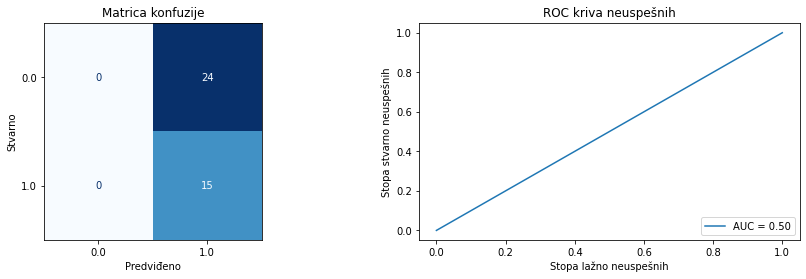

In [55]:
train_data, test_data = train_test_split(data, random_state=0, stratify=data[kolona_predikcije], test_size=0.3)

model = BayesianModel([(kolona_predikcije, att) for att in kolone_za_predikciju])

from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

model.fit(
    data=train_data,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=100,
    complete_samples_only=False
)

klasifikuj(model, test_data)

In [56]:
# scaled_test_data = (test_data-data.mean())/data.std()
# scaled_train_data = (train_data-data.mean())/data.std()
# scaled_train_data

In [57]:
# model_sa_skaliranim = BayesianModel([(kolona_predikcije, att) for att in kolone_za_predikciju])
#
# model_sa_skaliranim.fit(
#     data=scaled_train_data,
#     estimator=BayesianEstimator,
#     prior_type="BDeu",
#     # equivalent_sample_size=100,
#     complete_samples_only=False
# )
# klasifikuj(model_sa_skaliranim, scaled_test_data)